In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/tmp/ipykernel_15070/3213813731.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("./data/market/Rice.Nagpur.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,1702.0,2114.762369,335.921081,1480.501442,1742.011008,2208.322325,2391.117104,2689.498558


<Axes: xlabel='Date'>

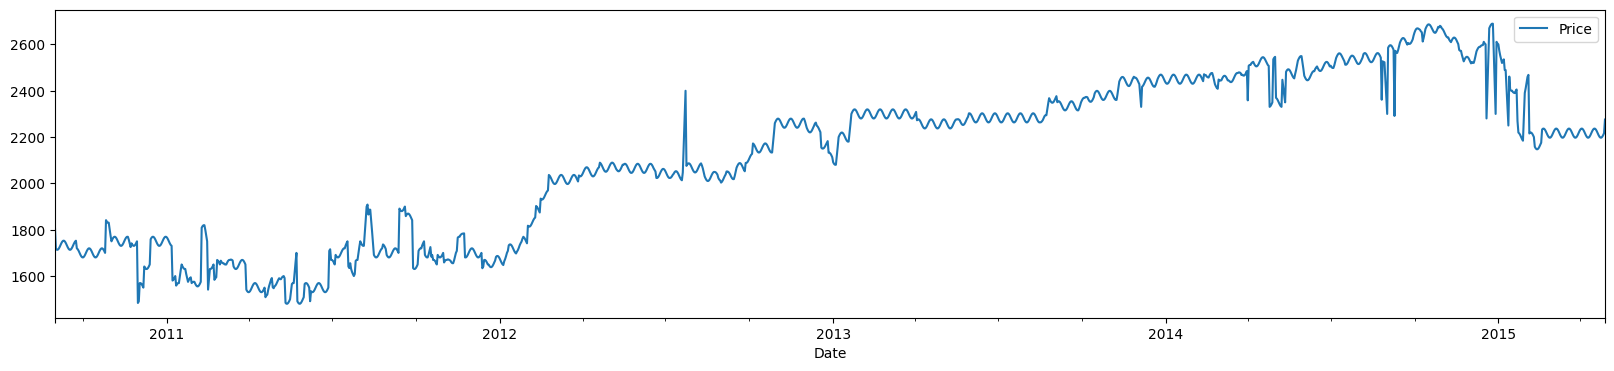

In [4]:
df.plot(figsize=(20, 4))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
result = seasonal_decompose(df, model="multiplicative")

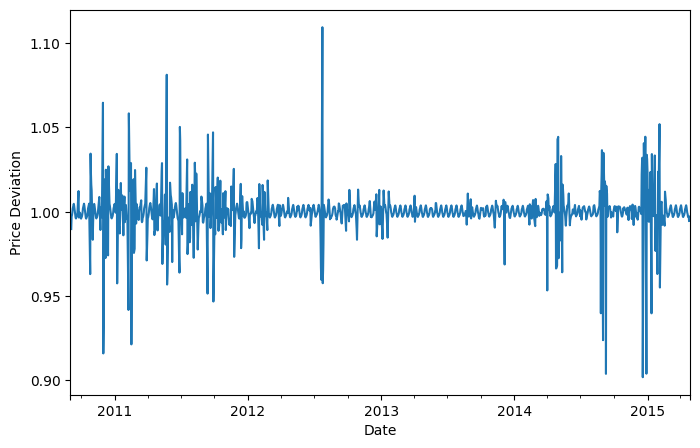

In [26]:
result.resid.plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

In [5]:
PREDICTION_DAYS = 28

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [11]:
sequence_length = 56

In [14]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [26]:
X.shape, y.shape

((1646, 56, 1), (1646,))

In [28]:
split = int(0.8 * len(X))

In [29]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [47]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 56, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
47/47 [==============================] - 4s 42ms/step - loss: 0.0298 - val_loss: 0.0032
Epoch 2/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 3/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 4/50
47/47 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 5/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 6/50
47/47 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 7/50
47/47 [==============================] - 2s 33ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/50
47/47 [==============================] - 2s 33ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 10/50
47/47 [==============================] - 2s 32ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/

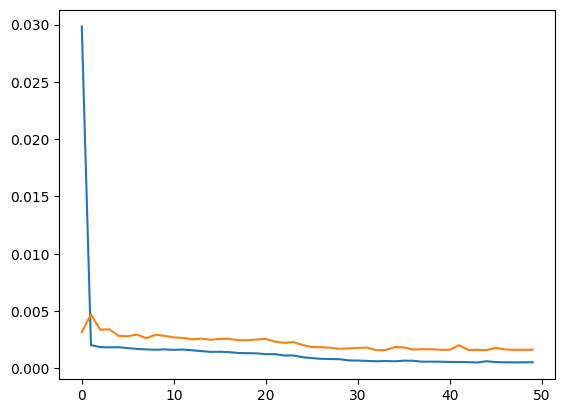

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [3]:
from joblib import dump, load

In [4]:
# model = load("./out/forecast.LSTM.Nagpur.Rice.joblib")

2023-12-23 15:21:33.447473: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 15:21:33.524861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 15:21:33.524911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 15:21:33.527981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 15:21:33.542202: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 15:21:33.543106: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [12]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [15]:
predictions = model.predict(X)

52/52 [==============================] - 1s 16ms/step


In [16]:
predictions = scaler.inverse_transform(predictions).flatten()

In [17]:
predictions.shape

(1646,)

In [18]:
from datetime import timedelta

In [19]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

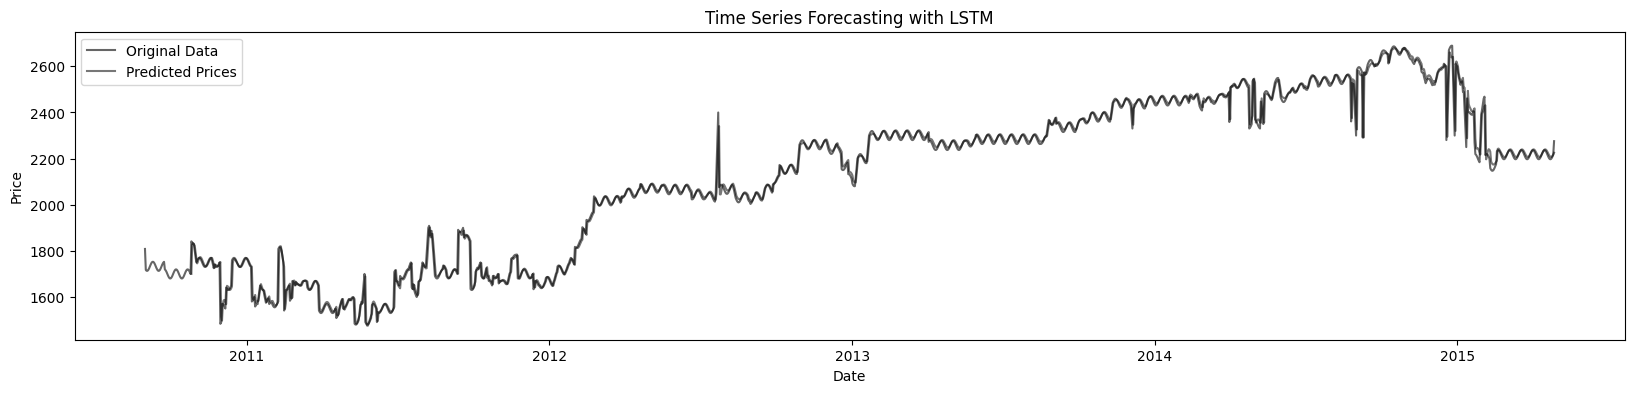

In [26]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [87]:
# dump(model, "./out/forecast.LSTM.Nagpur.Rice.joblib")

['./out/forecast.LSTM.Nagpur.Rice.joblib']

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

(14.216949747335736, 32.28489938988908)